<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, компании нужно прогнозировать количество заказов такси на следующий час, а нам необходимо построить модель для такого прогнозирования.

Для решения поставленной задачи будем придерживатья следующих шагов:

1. Загрузить данные и выполнить их ресемплирование по одному часу
2. Проанализировать данные
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных
4. Проверить данные на тестовой выборке и сделать выводы

В качестве оценки предсказанния мы будем использовать метрику RMSE. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
#импортируем нужные библиотеки
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import (
                Ridge,
                Lasso
)
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import (
                Pipeline, 
                make_pipeline
)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ( 
                TimeSeriesSplit,
                train_test_split,
                GridSearchCV,
                cross_val_score
)
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')


RANDOM_STATE = 42

Загрузим датафрейм:

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

Создадим функцию функцию, которая будет на вход принимает датафрейм, а на выходе выводит необходимые характеристики

In [3]:
def df_info(dataframe):
    print('Общая информация по датафрейму:')
    display(dataframe.info())
    print('\nПервые 10 строк:')
    display(dataframe.head(10))
    print('\nПоследние 10 строк:')
    display(dataframe.tail(10))
    print('\nПропуски:')
    display(dataframe.isnull().sum().sort_values(ascending=False))
    print('\nОписание датафрейма:')
    display(dataframe.describe())

In [4]:
df_info(df)

Общая информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


Первые 10 строк:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17



Последние 10 строк:


,num_orders
datetime,
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39



Пропуски:


num_orders    0
dtype: int64


Описание датафрейма:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Датафрейм содержит 26496 объектов и 2 признака.  
Столбец datetime приведен к формату datetime и выведен в индекс.  
Датафрейм не содержит пропущенных значений.  
Диапазон дат: с 01 марта 2018 г. по 31 августа 2018 г.  
Частота данных зафиксирована с интервалом 10 мин.  
В среднем мы имеем 14 заказов такси за 10 минут, максимум 119.  
Всего в нашей выборке 184 дня  

## Анализ

Проверим, все ли индексы у нас уникальны

In [5]:
print('Все индексы уникальны -', df.index.is_unique)

Все индексы уникальны - True


Ресемплируем дату по одному часу:

In [6]:
df = df.resample('1H').sum()

display(df.info())
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [7]:
display(df.index.max())
display(df.index.min())

Timestamp('2018-08-31 23:00:00', freq='H')

Timestamp('2018-03-01 00:00:00', freq='H')

Посмотрим на распределение таргета

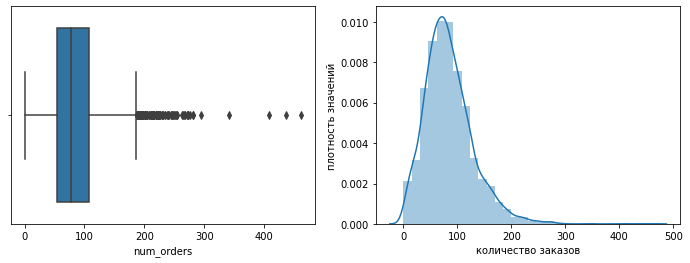

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(df['num_orders'], ax=axs[0])
sns.distplot(df['num_orders'], ax=axs[1], bins=30, rug=False)
plt.ylabel('плотность значений')
plt.xlabel('количество заказов');

In [9]:
df['num_orders'].quantile([0.0, 0.01, 0.02, 0.05, 0.1, 0.25, .5, .65, .75, .85, .93, .97, .99, 1]).transpose()

0.00      0.0
0.01      7.0
0.02     11.3
0.05     21.0
0.10     34.0
0.25     54.0
0.50     78.0
0.65     94.0
0.75    107.0
0.85    126.0
0.93    156.0
0.97    184.0
0.99    223.0
1.00    462.0
Name: num_orders, dtype: float64

По распределению значений можем наблюдать выбросы. Посмторим на цифры выше 300 заказов, это меньше 1% датафрейма.

In [10]:
df.query('num_orders >=300')

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


Все выбросы по понедельникам в августе ночью. Может быть, возвращаются отпускники, школьники и студенты массово именно в это время на вокзалы и в аэропорты

Посмотрим на общую картину нашего временного ряда

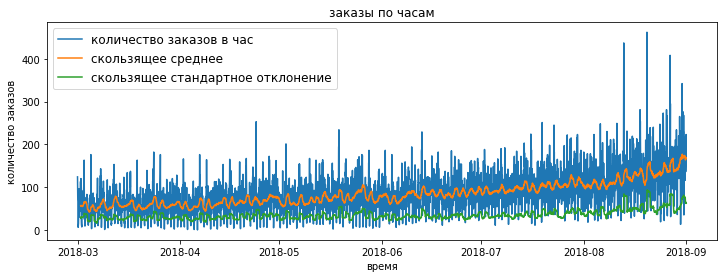

In [11]:
# построим график временного ряда
plt.figure(figsize=(12, 4))
plt.plot(df, label = 'количество заказов в час')
plt.plot(df.rolling(24).mean(), label = 'скользящее среднее')
plt.plot(df.rolling(24).std(), label = 'скользящее стандартное отклонение')

plt.legend(title='', loc='upper left', fontsize=12)
plt.xlabel('время')
plt.ylabel('количество заказов')
plt.title('заказы по часам')
plt.show;

Как видим тренд на повышение идет с начала апреля и до конца наблюдений
Видны переодичные всплески по месяцам, можно увидеть что в конце апреля есть большой всплеск, в мае, а также большее количество всплесков наблюдаем в августе

С ростом количества заказов увеличивается и скользящее среднее, и скользящее стандартное отклонение (в самом конце временного промежутка), что свидетельствует о том, что временной ряд является нестационарным.

Посмотрим на сезонность и тренд по всему датасету

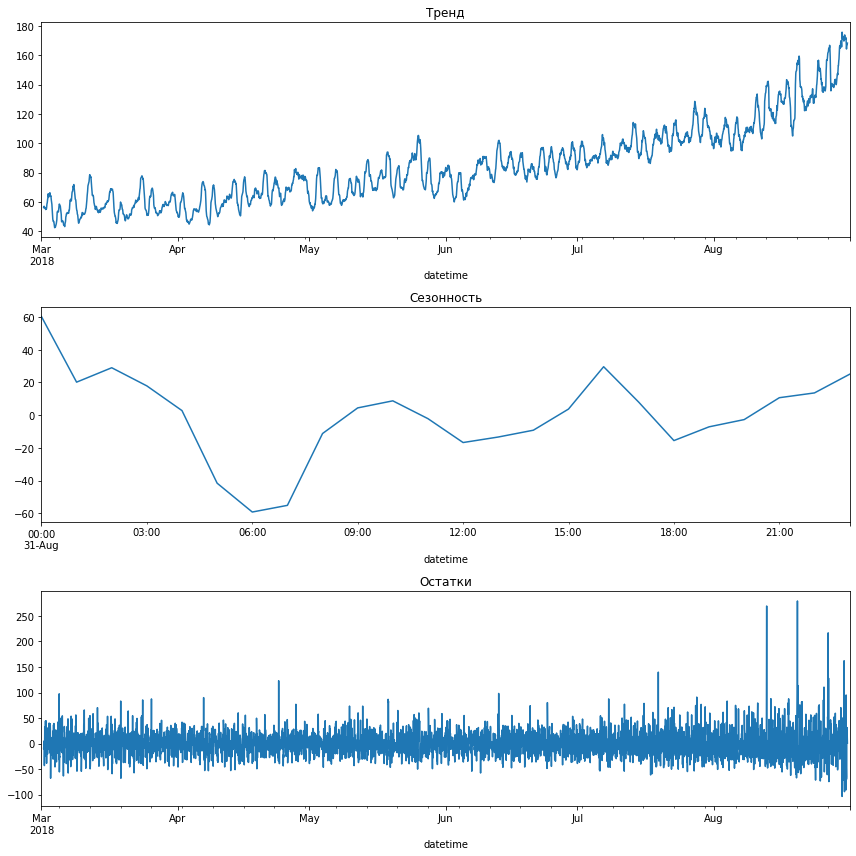

In [12]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

#посмотрим на дневную сезонность
decomposed.seasonal.tail(24).plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остатки')
plt.tight_layout()

Модель нужно обучать, в нашей выборке один признак - целевой, поэтому нужно создать дополнительные признаки.

Добавим такие:

day | день месяца  
month | номер месяца  
hour | час дня  
weekday | номер дня недели  
weekend | выходной ли день (0/1)  
daytime | период дня: утро/день/вечер/ночь (0-3)  
day_orders | общее количество машин в конкретное время суток предыдущего дня (потребуется сдвиг на сутки)  
lag_{...} | отстающие значения  
rolling_mean | скользящее среднее  
rolling_std | скользящее стандартное отклонение  

In [13]:
def make_features(data, rolling_window_size=5, lag_amount=5):

    df_ = df.copy()

    df_['day'] = df_.index.day
    df_['month'] = df_.index.month
    df_['weekday'] = df_.index.weekday
    df_['weekend'] = df_['weekday'].apply(
        lambda x: 1 if x in [5, 6] else 0)

    daytimes_ = {0: range(0, 7),
                 1: range(7, 13),
                 2: range(13, 19),
                 3: range(19, 24)}

    def daytimes(x):
        for dt in daytimes_.keys():
            if x in daytimes_[dt]:
                return dt

    df['hour'] = df_.index.hour

    df_['daytime'] = df['hour'].apply(daytimes)

    df_['day_orders'] = df_['num_orders'].shift(24)

    for lag in range(1, lag_amount+1):
        df_[f'lag_{lag}'] = df_['num_orders'].shift(lag)

    if type(rolling_window_size) is list:
        for window_size in rolling_window_size:

            df_[f'rolling_mean_{window_size}'] = (
                df_['num_orders'].shift().rolling(window_size).mean())

            df_[f'rolling_std_{window_size}'] = (
                df_['num_orders'].shift().rolling(window_size).std())
    else:
        df_[f'rolling_mean_{rolling_window_size}'] = (
            df_['num_orders'].shift().rolling(rolling_window_size).mean())

        df_[f'rolling_std_{rolling_window_size}'] = (
            df_['num_orders'].shift().rolling(rolling_window_size).std())

    print('Признаки созданы')
    return df_

In [14]:
df = make_features(df, [5, 20], 10)

df.head(10)

Признаки созданы


,num_orders,day,month,weekday,weekend,daytime,day_orders,lag_1,lag_2,lag_3,...,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean_5,rolling_std_5,rolling_mean_20,rolling_std_20
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,3,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,3,0,0,NaN,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,3,0,0,NaN,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,0,0,NaN,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,3,0,0,NaN,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,3,3,0,0,NaN,43.0,66.0,71.0,...,124.0,NaN,NaN,NaN,NaN,NaN,77.8,29.928248,NaN,NaN
2018-03-01 06:00:00,12,1,3,3,0,0,NaN,6.0,43.0,66.0,...,85.0,124.0,NaN,NaN,NaN,NaN,54.2,30.898220,NaN,NaN
2018-03-01 07:00:00,15,1,3,3,0,1,NaN,12.0,6.0,43.0,...,71.0,85.0,124.0,NaN,NaN,NaN,39.6,29.938270,NaN,NaN
2018-03-01 08:00:00,34,1,3,3,0,1,NaN,15.0,12.0,6.0,...,66.0,71.0,85.0,124.0,NaN,NaN,28.4,25.383065,NaN,NaN


Посмотрим, как зависит среднее число заказов от определенного дня месяца, дня недели, самого месяца, времени суток и от того, выходной ли день.

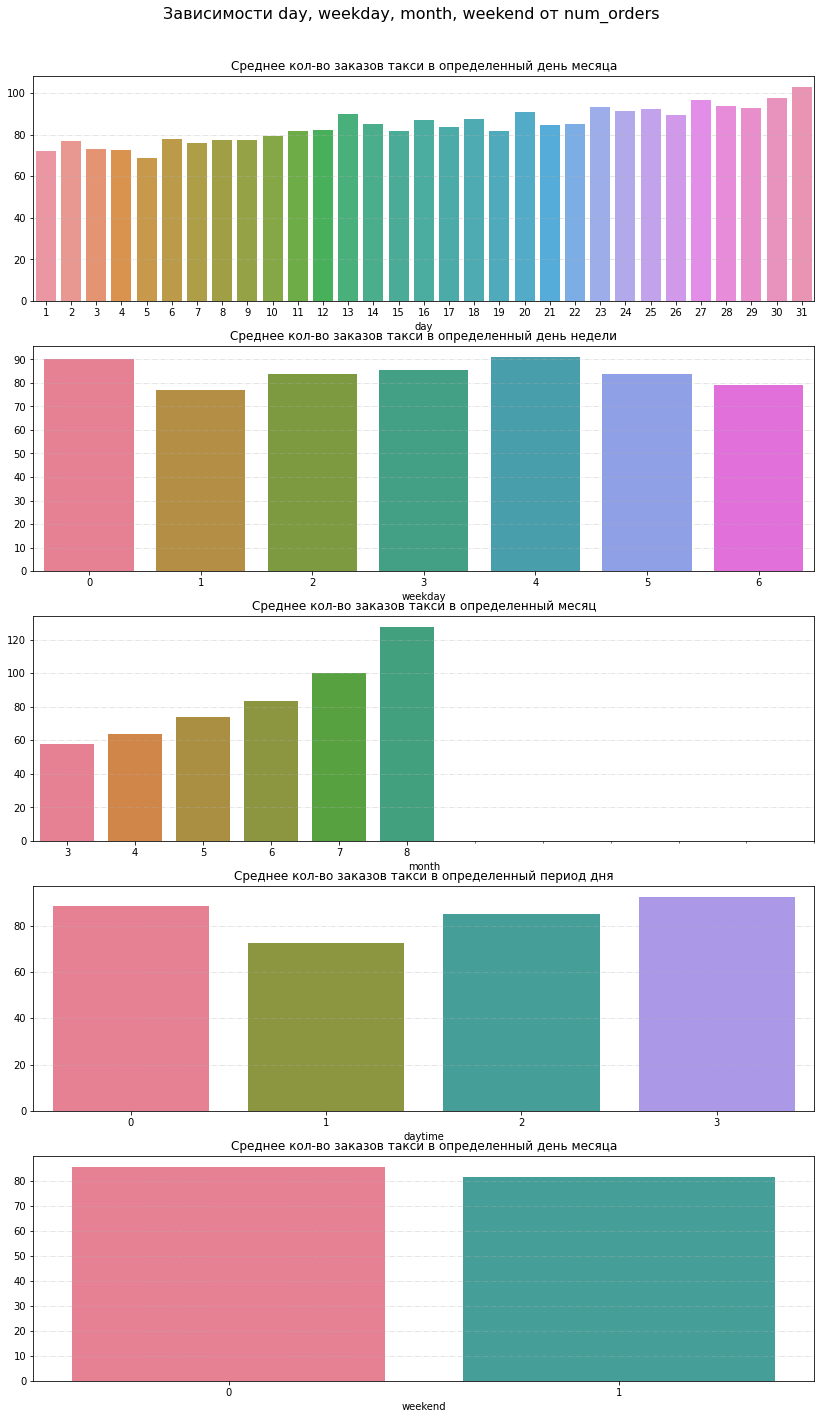

In [15]:
fig, ax = plt.subplots(5, 1, figsize=(14, 24))

fig.suptitle('Зависимости day, weekday, month, weekend от num_orders', fontsize=16, y=0.92)


def groupby_splitter(gb_data):
    return gb_data.index, gb_data.values


ax0_x, ax0_y = groupby_splitter(df.groupby('day')['num_orders'].mean())

ax[0].set_title('Среднее кол-во заказов такси в определенный день месяца')
sns.barplot(x=ax0_x, y=ax0_y, ax=ax[0])
ax[0].grid(axis='y', alpha=0.4, linestyle='-.')

ax1_x, ax1_y = groupby_splitter(df.groupby('weekday')['num_orders'].mean())

ax[1].set_title('Среднее кол-во заказов такси в определенный день недели')
sns.barplot(x=ax1_x, y=ax1_y, ax=ax[1], palette=sns.color_palette("husl", 7))
ax[1].set_xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
ax[1].set_yticks(range(0, 100, 10))
ax[1].grid(axis='y', alpha=0.4, linestyle='-.')


ax2_x, ax2_y = groupby_splitter(df.groupby('month')['num_orders'].mean())

ax[2].set_title('Среднее кол-во заказов такси в определенный месяц')
sns.barplot(x=ax2_x, y=ax2_y, ax=ax[2], palette=sns.color_palette("husl", 12))
ax[2].set_xticks(range(12), ['Янв', 'Фев', 'Март', 'Апрель',
                 'Май', 'Июнь', 'Июль', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
ax[2].grid(axis='y', alpha=0.4, linestyle='-.')


ax3_x, ax3_y = groupby_splitter(df.groupby('daytime')['num_orders'].mean())

ax[3].set_title('Среднее кол-во заказов такси в определенный период дня')
sns.barplot(x=ax3_x, y=ax3_y, ax=ax[3], palette=sns.color_palette("husl", 4))
ax[3].set_xticks(range(4), ['Ночь', 'Утро', 'День', 'Вечер'])
ax[3].grid(axis='y', alpha=0.4, linestyle='-.')


ax4_x, ax4_y = groupby_splitter(df.groupby('weekend')['num_orders'].mean())

ax[4].set_title('Среднее кол-во заказов такси в определенный день месяца')
sns.barplot(x=ax4_x, y=ax4_y, ax=ax[4], palette=sns.color_palette("husl", 2))
ax[4].set_xticks(range(2), ['Будние', 'Выходные'])
ax[4].grid(axis='y', alpha=0.4, linestyle='-.')

plt.show()

Количество заказов растет как и к концу месяца, так и в целом с каждым последующим месяцем.  
Понедельник и пятница лидеры по количеству заказов, чтов  целом закономерно.  
Больше всего такси заказывают вечером и ночью.   
В будние больше заказов.   
Но при этом нельзя сказать, что разница по сравниваемым периодам выдающаяся, прочто небольшой рост в упомянутые периоды.

Постоим матрицу корреляции и оценим корелляцию добавленных признаков, если она будет сильная, эти признаки удалим.

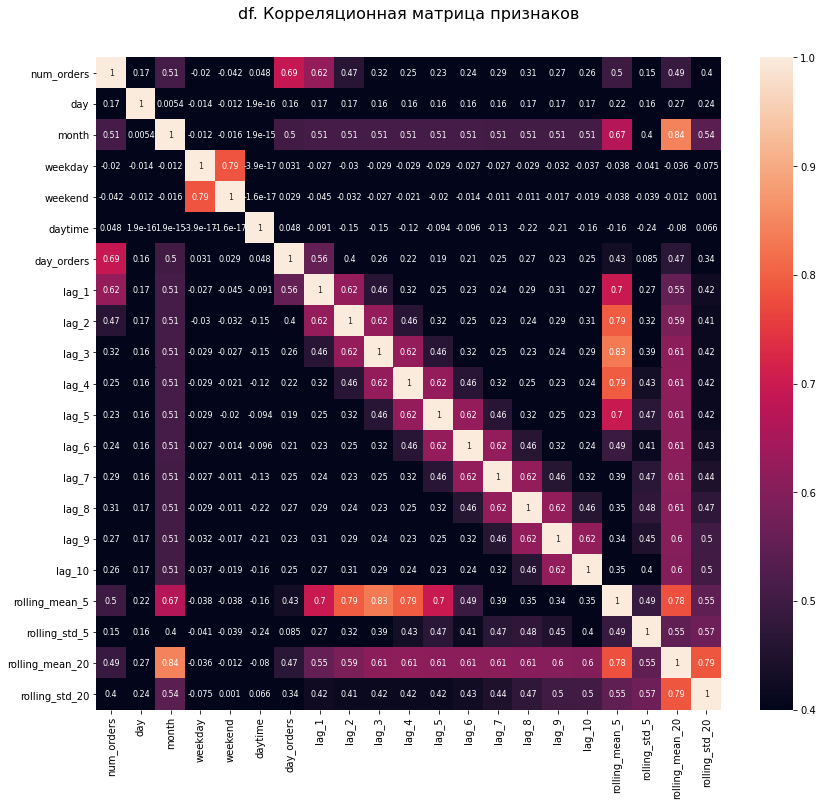

In [16]:
plt.figure(figsize=(14, 12))
plt.title('df. Корреляционная матрица признаков', y=1.05, fontsize=16)

sns.heatmap(df.corr(), annot=True, vmin=0.4, vmax=1, annot_kws={"fontsize": 8})

plt.show()

## Обучение

Создадим тренировочную и тестовую выборки

In [17]:
train, test = train_test_split(df, test_size=.1, shuffle=False)
train.dropna(inplace=True)

X_train = train.drop(columns=[f'lag_{i}' for i in range(1, 3)] + ['num_orders'])
y_train = train['num_orders']

X_test = test.drop(columns=[f'lag_{i}' for i in range(1, 3)] + ['num_orders'])
y_test = test['num_orders']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3950, 18), (3950,), (442, 18), (442,))

Так как будут использоваться в том числе и линейные модели, то следует отмасштабировать признаки. Будем ипользовать StandardScaler

In [18]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(
    X_train), columns=X_train.columns, index=y_train.index)

X_test = pd.DataFrame(scaler.transform(
    X_test), columns=X_test.columns, index=y_test.index)

display(X_train.head())
display(X_test.head())

print(X_train.index.is_monotonic)
X_test.index.is_monotonic

,day,month,weekday,weekend,daytime,day_orders,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean_5,rolling_std_5,rolling_mean_20,rolling_std_20
datetime,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,-1.494371,-1.424268,0.48532,-0.641656,-1.235394,1.211966,-0.320444,-0.449344,-0.862885,-0.138173,-0.888716,-0.914359,-0.319071,-0.784449,-0.349639,-0.082493,-1.368421,-0.696600
2018-03-02 01:00:00,-1.494371,-1.424268,0.48532,-0.641656,-1.235394,0.186112,0.895012,-0.319978,-0.448830,-0.862776,-0.138210,-0.888482,-0.914238,-0.318537,-0.028007,-0.284818,-1.250695,-0.540913
2018-03-02 02:00:00,-1.494371,-1.424268,0.48532,-0.641656,-1.235394,-0.182143,-0.527331,0.896068,-0.319438,-0.448717,-0.862836,-0.138046,-0.888361,-0.913869,0.393689,0.036984,-0.965146,-0.368883
2018-03-02 03:00:00,-1.494371,-1.424268,0.48532,-0.641656,-1.235394,-0.313663,0.300214,-0.526964,0.896848,-0.319324,-0.448764,-0.862605,-0.137933,-0.887985,0.458016,-0.095668,-0.807342,-0.605684
2018-03-02 04:00:00,-1.494371,-1.424268,0.48532,-0.641656,-1.235394,-0.918654,1.076037,0.300982,-0.526465,0.896976,-0.319366,-0.448572,-0.862484,-0.137349,0.107793,-0.180250,-0.684606,-0.884518


,day,month,weekday,weekend,daytime,day_orders,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean_5,rolling_std_5,rolling_mean_20,rolling_std_20
datetime,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,-0.249587,1.752748,-1.507418,-0.641656,0.565272,0.685887,1.696696,2.008621,1.517930,0.327644,-1.018113,-0.319186,0.120835,1.674530,1.830314,-0.168265,3.105181,6.475831
2018-08-13 15:00:00,-0.249587,1.752748,-1.507418,-0.641656,0.565272,1.869565,0.351936,1.698141,2.009620,1.518065,0.327622,-1.017868,-0.319071,0.121491,1.580156,0.007919,3.165296,6.386994
2018-08-13 16:00:00,-0.249587,1.752748,-1.507418,-0.641656,0.565272,1.974781,1.050177,0.352729,1.699079,2.009760,1.518079,0.327742,-1.017745,-0.318537,1.715956,0.517551,3.398244,6.282849
2018-08-13 17:00:00,-0.249587,1.752748,-1.507418,-0.641656,0.565272,0.975231,0.610543,1.051308,0.353401,1.699216,2.009790,1.518089,0.327850,-1.017405,1.715956,0.517551,3.513466,6.193356
2018-08-13 18:00:00,-0.249587,1.752748,-1.507418,-0.641656,0.565272,0.001984,2.498380,0.611462,1.052118,0.353523,1.699236,2.009754,1.518183,0.328563,2.144800,0.118472,3.556048,6.186666


True


True

In [19]:
split = TimeSeriesSplit(n_splits=5)

In [20]:
#функция для кросс валидации (подбора модели без гиперпараметров)
def cross_val(model):
    cvs = cross_val_score(model, X_train, y_train, cv=split,
                          scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return print("Лучшее значение",  model,  "на кросс валидации:", -cvs)

In [21]:
cross_val(Ridge(random_state=RANDOM_STATE))

Лучшее значение Ridge(random_state=42) на кросс валидации: 27.088232927250413


In [22]:
cross_val(Lasso(random_state=RANDOM_STATE))

Лучшее значение Lasso(random_state=42) на кросс валидации: 28.21620090594022


In [23]:
cross_val(LGBMRegressor(random_state=RANDOM_STATE))

Лучшее значение LGBMRegressor(random_state=42) на кросс валидации: 26.50955677075955


In [24]:
cross_val(CatBoostRegressor(random_state=RANDOM_STATE))

Learning rate set to 0.038341
0:	learn: 29.2749500	total: 52.3ms	remaining: 52.3s
1:	learn: 28.7656741	total: 54.8ms	remaining: 27.4s
2:	learn: 28.2875655	total: 56.9ms	remaining: 18.9s
3:	learn: 27.8300260	total: 59.1ms	remaining: 14.7s
4:	learn: 27.3338825	total: 61.3ms	remaining: 12.2s
5:	learn: 27.0031723	total: 63.5ms	remaining: 10.5s
6:	learn: 26.6867004	total: 65.7ms	remaining: 9.32s
7:	learn: 26.3652636	total: 68.1ms	remaining: 8.44s
8:	learn: 26.0048798	total: 70.4ms	remaining: 7.75s
9:	learn: 25.6592713	total: 72.6ms	remaining: 7.19s
10:	learn: 25.3619969	total: 75.1ms	remaining: 6.75s
11:	learn: 25.0419711	total: 77.2ms	remaining: 6.36s
12:	learn: 24.7473837	total: 79.6ms	remaining: 6.05s
13:	learn: 24.4235129	total: 82.1ms	remaining: 5.78s
14:	learn: 24.1392101	total: 84.3ms	remaining: 5.54s
15:	learn: 23.9099551	total: 86.6ms	remaining: 5.33s
16:	learn: 23.6643737	total: 89ms	remaining: 5.15s
17:	learn: 23.4086257	total: 91.4ms	remaining: 4.99s
18:	learn: 23.1452674	total:

По итогам кросс валидации у нас лидируют Ridge, LGBM и CatBoost

In [25]:
%%time
rg = Pipeline(steps=[('regressor', Ridge(random_state=RANDOM_STATE))])


#задаем параметры для grid search
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1]
}

#создаем объект GridSearchCV
s_rg = GridSearchCV(rg, param_grid=param_grid, cv=split,
                      scoring='neg_root_mean_squared_error',
                      refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_rg.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_rg.best_params_)
print("Лучшее значение: ", -s_rg.best_score_)

Лучшие параметры:  {'regressor__alpha': 1}
Лучшее значение:  27.088232927250413
CPU times: user 918 ms, sys: 1.09 s, total: 2.01 s
Wall time: 1.98 s


In [26]:
%%time
lgbm = Pipeline(steps=[('regressor', LGBMRegressor(random_state=RANDOM_STATE))])

param_grid = {
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__n_estimators' : range(100, 400, 50),
    'regressor__max_depth' : range(10, 16 , 5),
}

s_lgbm = GridSearchCV(lgbm, param_grid=param_grid, cv=split,
                      scoring='neg_root_mean_squared_error',
                      refit=True, error_score='raise', n_jobs=-1)

s_lgbm.fit(X_train, y_train)

print("Лучшие параметры: ", s_lgbm.best_params_)
print("Лучшее значение: ", -s_lgbm.best_score_)

Лучшие параметры:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 15, 'regressor__n_estimators': 100}
Лучшее значение:  26.441700353123355
CPU times: user 16min 47s, sys: 5.87 s, total: 16min 53s
Wall time: 16min 59s


In [27]:
%%time
cb = Pipeline(steps=[('regressor', CatBoostRegressor(random_state=RANDOM_STATE))])
param_grid = {
    'regressor__learning_rate': [0.1, 0.3, 0.01],
    'regressor__n_estimators': range(100, 301, 100),
}

s_cb = GridSearchCV(cb, param_grid=param_grid, cv=split,
                    scoring='neg_root_mean_squared_error', refit=True, error_score='raise', n_jobs=-1)

s_cb.fit(X_train, y_train)

print("Лучшие параметры: ", s_cb.best_params_)
print("Лучшее значение: ", -s_cb.best_score_)

0:	learn: 28.6286392	total: 2.64ms	remaining: 262ms
1:	learn: 27.3928036	total: 5.27ms	remaining: 258ms
2:	learn: 26.3074890	total: 8.77ms	remaining: 283ms
3:	learn: 25.3423404	total: 12.9ms	remaining: 310ms
4:	learn: 24.3412135	total: 17ms	remaining: 322ms
5:	learn: 23.8398364	total: 21.2ms	remaining: 333ms
6:	learn: 23.2973105	total: 25.1ms	remaining: 333ms
7:	learn: 22.7609727	total: 29ms	remaining: 333ms
8:	learn: 22.0982613	total: 33ms	remaining: 333ms
9:	learn: 21.5866784	total: 35.4ms	remaining: 319ms
10:	learn: 21.1943708	total: 39ms	remaining: 315ms
11:	learn: 20.7375133	total: 41.7ms	remaining: 306ms
12:	learn: 20.4099292	total: 44.3ms	remaining: 297ms
13:	learn: 20.0460962	total: 46.6ms	remaining: 286ms
14:	learn: 19.6932413	total: 48.9ms	remaining: 277ms
15:	learn: 19.3528096	total: 51.3ms	remaining: 269ms
16:	learn: 19.0738917	total: 53.6ms	remaining: 262ms
17:	learn: 18.7714548	total: 55.8ms	remaining: 254ms
18:	learn: 18.5221697	total: 58.1ms	remaining: 248ms
19:	learn: 

Все три модели показывают неплохой результат, поэтому сделаем bagging для двух моделей-Ridge(линейная) (линейные модели хорошо экстраполируют, чтобы строить прогноз не только на ближайший час, но и видеть тренды), и CatBoost.

In [29]:
catboost = s_cb.best_estimator_
ridge = s_rg.best_estimator_

#создаем бэггинг-модель
bagging = BaggingRegressor(base_estimator=catboost, n_estimators=6, random_state=RANDOM_STATE)

pipeline = Pipeline([('bagging', bagging)
])

param_grid = { }

search_bagging = GridSearchCV(pipeline, param_grid=param_grid, cv=split,
                              scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)

search_bagging.fit(X_train, y_train)

print("Best cross-validation score: ", -search_bagging.best_score_)

0:	learn: 28.5342384	total: 2.57ms	remaining: 511ms
1:	learn: 27.3404728	total: 5.08ms	remaining: 503ms
2:	learn: 26.2328964	total: 8.69ms	remaining: 571ms
3:	learn: 25.4491098	total: 11.6ms	remaining: 568ms
4:	learn: 24.6656276	total: 13.9ms	remaining: 541ms
5:	learn: 23.7760343	total: 16ms	remaining: 517ms
6:	learn: 23.0097638	total: 18.4ms	remaining: 507ms
7:	learn: 22.3458475	total: 20.6ms	remaining: 495ms
8:	learn: 21.7070320	total: 22.8ms	remaining: 483ms
9:	learn: 21.0804455	total: 25ms	remaining: 474ms
10:	learn: 20.4418212	total: 27.2ms	remaining: 468ms
11:	learn: 19.9250848	total: 29.4ms	remaining: 460ms
12:	learn: 19.4799120	total: 31.6ms	remaining: 455ms
13:	learn: 19.1839084	total: 34ms	remaining: 451ms
14:	learn: 18.7672337	total: 36.2ms	remaining: 446ms
15:	learn: 18.3348180	total: 38.3ms	remaining: 441ms
16:	learn: 17.9708782	total: 40.6ms	remaining: 437ms
17:	learn: 17.5814217	total: 42.8ms	remaining: 433ms
18:	learn: 17.1689507	total: 45ms	remaining: 429ms
19:	learn: 

Бэггинг показал лучшие результаты, на нем и сделаем тест.

## Тестирование

Константная модель

In [30]:
dummy = Pipeline(steps=[('regressor',DummyRegressor(strategy="mean"))
])

dummy.fit(X_train, y_train)

test_model = dummy.predict(X_test)

RMSE = mean_squared_error(y_test, test_model, squared=False)

print('RMSE DummyRegressor равен:', round(RMSE, 2))

RMSE DummyRegressor равен: 84.65


In [31]:
%%time
bg = search_bagging.best_estimator_.predict(X_test)
RMSE = mean_squared_error(y_test, bg, squared=False)
print('RMSE Bagging тест равен:', round(RMSE, 2))

RMSE Bagging тест равен: 43.29
CPU times: user 9.38 ms, sys: 16 µs, total: 9.39 ms
Wall time: 8.78 ms


Модель победитель CatBoost & Ridge (Bagging Regressor)

RMSE обучающей выборки: 25.05
RMSE тестовой выборки: 43.29

In [32]:
def final_plot(df):
    """
    Функция строит графики истинных значений и предсказания
    """    
    plt.figure(figsize=(15, 5))
    for i in range(len(df.columns)):
        plt.plot(df.iloc[:, i], lw=2, label=df.columns[i], alpha=.9)    
    plt.title('Cравнение предсказания с истинными значениями')
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', linewidth=.25, linestyle='--')
    plt.tight_layout()
    plt.show()


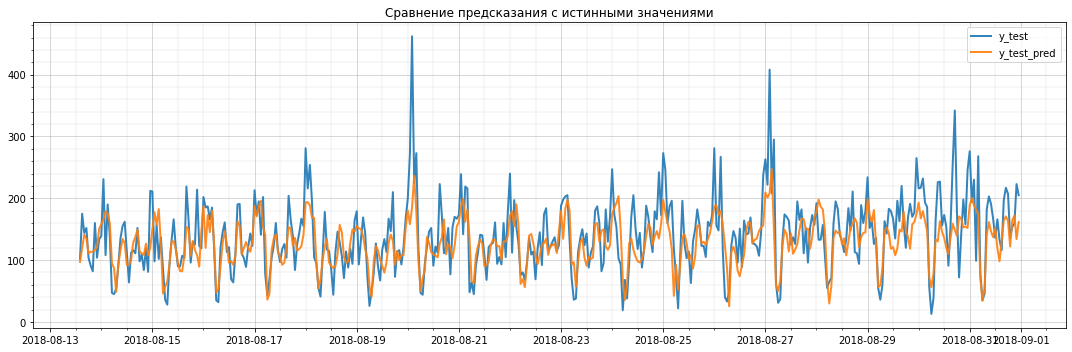

In [33]:
final_plot(pd.DataFrame({'y_test': y_test, 'y_test_pred': bg}))

## Вывод:

В ходе работы над проектом:  
1. Загрузили данные и выполнить их ресемплирование по одному часу.  
2. Провели анализ датафрейма. Создали новые признаки на основе даты и времени.
3. Обучили 4 модели:
   Lasso
   Ridge
   LGBMRegressor
   CatBoostRegressor
4. Обнаружили, что лучшую RMSE метрику на тестовой выборке показала bagging Ridge+CatBoost
5. Протестировали пресказание лучшей модели  на тестовой выборке и получили RMSE метрику 40.29 против константной модели с метрикой 84.65
По заданию, значение RMSE на тестовой выборке должно быть не больше 48, его мы и добились.